In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

df = pd.read_csv('input.csv')
df_output = pd.read_csv('output.csv')
df['label'] = df_output['label']  # 1: FAKE, 0: REAL

df['sentiment_label_encoded'] = LabelEncoder().fit_transform(df['sentiment_label'])

X = df[['title_length', 'text_length', 'sentiment_score', 'sentiment_label_encoded']]
y = df['label']

# 정규화 과정
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# 모델 정의 (가장 높은 정확성의 모델 선택하기 위한 테스트)
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "SVM": SVC(),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier()
}

# 모델 학습 및 평가
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results.append((name, acc, f1))

    print(f"📌 {name}")
    print(classification_report(y_test, y_pred, target_names=["FAKE", "REAL"]))
    print("-" * 50)

results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "F1 Score"])
results_df = results_df.sort_values(by="F1 Score", ascending=False)

print("\n🎯 모델 성능 비교:")
print(results_df)

📌 Logistic Regression
              precision    recall  f1-score   support

        FAKE       0.78      0.84      0.81      4247
        REAL       0.84      0.79      0.82      4733

    accuracy                           0.81      8980
   macro avg       0.81      0.81      0.81      8980
weighted avg       0.81      0.81      0.81      8980

--------------------------------------------------
📌 Random Forest
              precision    recall  f1-score   support

        FAKE       0.83      0.85      0.84      4247
        REAL       0.86      0.84      0.85      4733

    accuracy                           0.84      8980
   macro avg       0.84      0.84      0.84      8980
weighted avg       0.84      0.84      0.84      8980

--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:02:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📌 XGBoost
              precision    recall  f1-score   support

        FAKE       0.80      0.89      0.84      4247
        REAL       0.89      0.81      0.85      4733

    accuracy                           0.85      8980
   macro avg       0.85      0.85      0.85      8980
weighted avg       0.85      0.85      0.85      8980

--------------------------------------------------
📌 SVM
              precision    recall  f1-score   support

        FAKE       0.77      0.90      0.83      4247
        REAL       0.89      0.76      0.82      4733

    accuracy                           0.82      8980
   macro avg       0.83      0.83      0.82      8980
weighted avg       0.83      0.82      0.82      8980

--------------------------------------------------
📌 Naive Bayes
              precision    recall  f1-score   support

        FAKE       0.73      0.90      0.80      4247
        REAL       0.88      0.70      0.78      4733

    accuracy                           0.79      8

## ! 모델 성능 비교 결과 해석

| 순위   | 모델 이름                   | 정확도 (Accuracy) | F1 Score  | 해석 요약                             |
| ---- | ----------------------- | -------------- | --------- | --------------------------------- |
| 🥇 1 | **Random Forest**       | 84.2%          | **0.849** | 가장 높은 F1 점수 → FAKE/REAL 모두 잘 분류   |
| 🥈 2 | **XGBoost**             | **84.5%**      | 0.846     | 정확도는 제일 높음, 하지만 F1은 RF보다 살짝 낮음    |
| 🥉 3 | **KNN**                 | 82.1%          | 0.826     | 꽤 선방했지만 주변 이웃이 많아질수록 정확도 흔들릴 수 있음 |
| 4    | **SVM**                 | 82.3%          | 0.819     | 마진 기반 분류지만 정규화된 수치만 사용했을 경우 한계    |
| 5    | **Logistic Regression** | 81.2%          | 0.816     | 기본 모델로 나쁘지 않음, 해석은 쉬움             |
| 6    | **Naive Bayes**         | 79.2%          | 0.780     | 간단하고 빠르지만 텍스트 특성 반영 부족            |


## Random Forest 모델로 확정!!

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


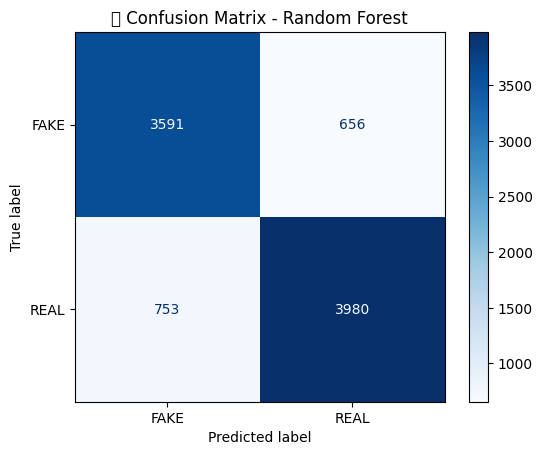

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 예측
y_pred = models["Random Forest"].predict(X_test)

# 혼동 행렬 생성 및 시각화
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["FAKE", "REAL"])
disp.plot(cmap="Blues")
plt.title("📊 Confusion Matrix - Random Forest")
plt.show()

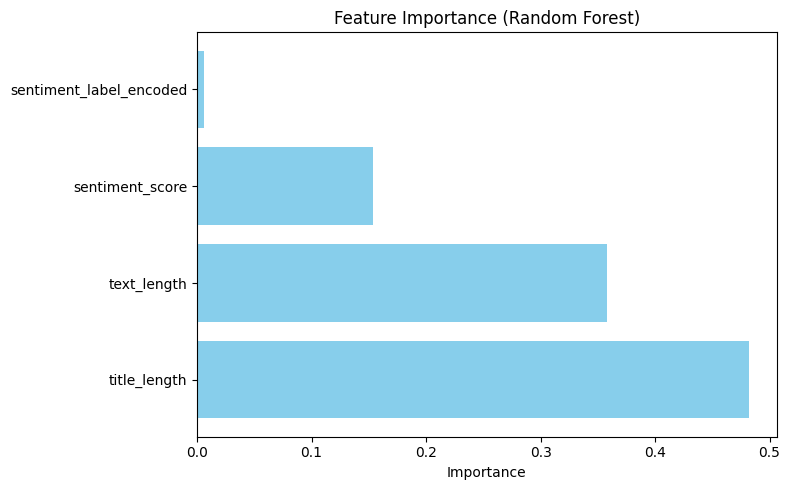

In [6]:
importances = models["Random Forest"].feature_importances_
feature_names = X.columns

plt.figure(figsize=(8, 5))
plt.barh(feature_names, importances, color="skyblue")
plt.xlabel("Importance")
plt.title("Feature Importance (Random Forest)")
plt.tight_layout()
plt.show()

## 임의로 테스트한 코드

In [18]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

title = "Shocking! COVID-19 vaccine turns people into zombies, says secret report"
text = """
A leaked document from a so-called whistleblower claims that the COVID-19 vaccine alters human DNA
and causes irreversible brain damage. Experts are warning that a major cover-up is underway.
"""

title_length = len(title.split())
text_length = len(text.split())

nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()
sentiment_score = sid.polarity_scores(title)['compound']

def classify_sentiment(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

sentiment_label = classify_sentiment(sentiment_score)

# 숫자 인코딩 (기존 학습된 encoder 사용)
sentiment_label_encoded = LabelEncoder().fit(['negative', 'neutral', 'positive']).transform([sentiment_label])[0]

input_vector = [[title_length, text_length, sentiment_score, sentiment_label_encoded]]

input_scaled = scaler.transform(input_vector)

prediction = models["Random Forest"].predict(input_scaled)[0]

# 0 = REAL, 1 = FAKE
proba = models["Random Forest"].predict_proba(input_scaled)[0]
fake_prob = proba[1]
real_prob = proba[0]

if real_prob > 0.8:
    print("✅ 매우 신뢰할 수 있는 REAL 기사입니다.")
elif real_prob > 0.6:
    print("⚠️ 신뢰도 중간 정도입니다.")
else:
    print("❗ FAKE일 가능성도 있습니다. 추가 확인 필요.")

print(f"🧠 예측 결과: {'REAL' if real_prob > fake_prob else 'FAKE'}")
print(f"🔍 FAKE 확률: {fake_prob * 100:.1f}%")
print(f"🔍 REAL 확률: {real_prob * 100:.1f}%")

⚠️ 신뢰도 중간 정도입니다.
🧠 예측 결과: REAL
🔍 FAKE 확률: 31.0%
🔍 REAL 확률: 69.0%


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
